# 密度聚类方法实现与应用
密度聚类通过评估样本的紧密程度来划分对应的类别，理论上可以找出任何形状的聚类并有效避免噪声的干扰。除此之外，密度聚类和层次聚类一样，也无需像划分聚类那样提前声明需要聚集的类别数量

层次聚类有一些先天性的缺点无法避免，例如它和划分聚类方法一样，无法很好地接近非凸（non-convex）数据的聚类问题

## DBSCAN聚类
* 首先，DBSCAN 会以每个数据点为圆心，以$eps$($\epsilon$-邻域) 为半径画圆
* 然后，DBSCAN 会计算相应圆中有多少个其他点，并以该数目作为圆心数据点的密度值
* 接下来，我们需要确定密度阈值 MinPts，并分别将小于或大于该密度阈值的数据点（包含自己）称作低密度或高密度点（核心点）
* 如果，此时有一个高密度的点在另一个高密度的点的圆圈范围内，我们就把这两个点串联起来
* 之后，如果有低密度的点也在高密度的点的圆圈范围内，也将其连接到最近的高密度点上，并称之为边界点

In [1]:
# 生成一组月牙形状的数据集
from sklearn import datasets

noisy_moons, _ = datasets.make_moons(
    n_samples=100, noise=0.05, random_state=10
)  # 生成 100 个样本并添加噪声
noisy_moons[:5]

array([[ 0.2554364 ,  0.90420806],
       [ 0.55299636,  0.84445141],
       [-0.90343862,  0.39161309],
       [-0.62792219,  0.62502915],
       [ 0.60777269, -0.33777687]])

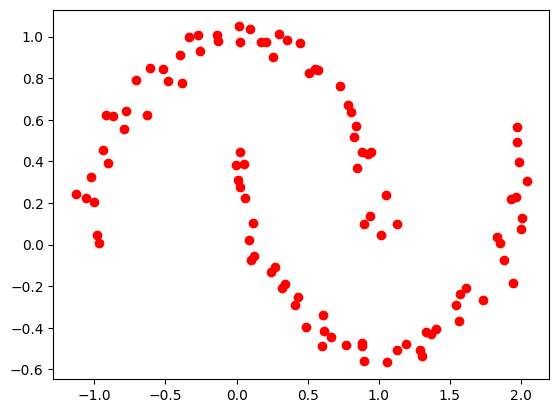

In [5]:
# 绘制
from matplotlib import pyplot as plt

%matplotlib inline

plt.scatter(noisy_moons[:, 0], noisy_moons[:, 1], c='r')

Text(0.5, 0, 'BIRCH')

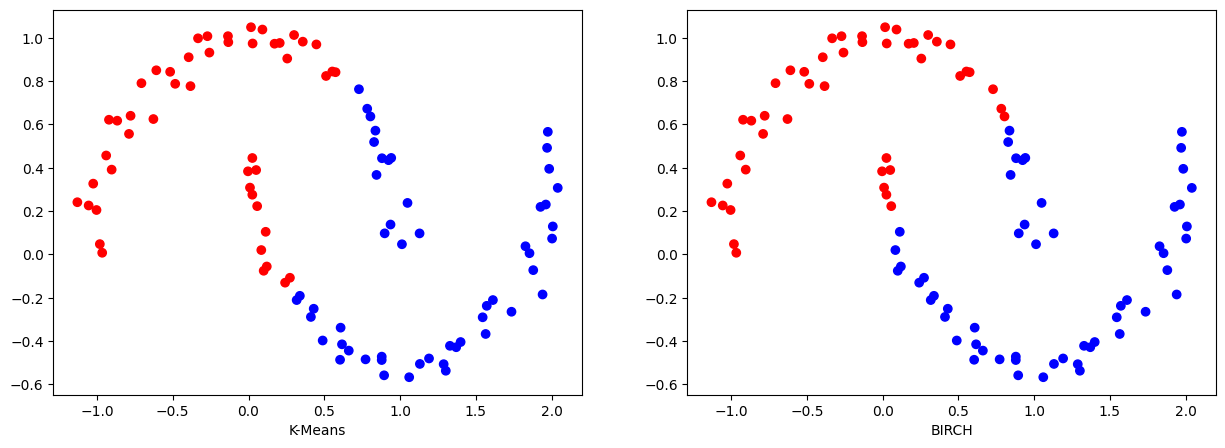

In [6]:
# 尝试用划分聚类中的K-Means聚类和层次聚类中的BIRCH方法
from sklearn.cluster import KMeans, Birch

kmeans_c = KMeans(n_clusters=2, n_init="auto").fit_predict(noisy_moons)
birch_c = Birch(n_clusters=2).fit_predict(noisy_moons)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].scatter(noisy_moons[:, 0], noisy_moons[:, 1], c=kmeans_c, cmap="bwr")
axes[1].scatter(noisy_moons[:, 0], noisy_moons[:, 1], c=birch_c, cmap="bwr")
axes[0].set_xlabel("K-Means")
axes[1].set_xlabel("BIRCH")

In [10]:
# 实现DBSCAN密度聚类
# 首先实现search_neighbors() 函数，这个函数的目的是找出核心点周围可到达的数据点
import numpy as np

def euclidean_distance(a, b):
    """
    参数:
    a -- 数组 a
    b -- 数组 b

    返回:
    dist -- a, b 间欧式距离
    """
    # 欧式距离
    x = float(a[0]) - float(b[0])
    x = x * x
    y = float(a[1]) - float(b[1])
    y = y * y
    dist = round(np.sqrt(x + y), 2)
    return dist

# 随后是寻找邻居的函数
def search_neighbors(D, P, eps):
    """
    参数:
    D -- 数据集（二维数组）
    P -- 核心点
    eps -- eps 邻域

    返回:
    neighbors -- 核心点在 eps 范围内的邻居
    """
    # 找出数据集中距核心点 P 在 eps 范围内的邻近点
    neighbors = []
    for Pn in range(0, len(D)):
        # 距离判断是否在 eps 范围内
        if euclidean_distance(D[P], D[Pn]) < eps:
            neighbors.append(Pn)

    return neighbors

In [8]:
# DBSCAN的主体代码
def dbscan_cluster(D, eps, MinPts):
    """
    参数:
    D -- 数据集（二维数组）
    eps -- eps 邻域
    MinPts -- 密度阀值

    返回:
    labels -- 聚类标签
    """
    # DBSCAN 密度聚类算法
    labels = [0] * len(D)  # 初始化数据集中的数据类别全部为 0
    C = 0
    # 选择 P 作为核心点
    for P in range(0, len(D)):
        # 选择类别为 0 的点作为中心
        if not (labels[P] == 0):
            continue

        # 搜寻该数据点在 eps 圆中的邻居
        Neighbors = search_neighbors(D, P, eps)

        # 标记噪声点为 -1
        if len(Neighbors) < MinPts:
            labels[P] = -1

        # 非噪声点作为新类别中心
        else:
            C += 1  # 原类别 +1 作为新类别的标签
            labels[P] = C  # 将非噪声点设定为新类别

            # 开始检查 P 在 eps 圆中邻居的可达性
            for i, n in enumerate(Neighbors):
                Pn = Neighbors[i]  # 从 P 的邻居中取 1 个点

                # P 的邻居，设定为一样的类别
                if labels[Pn] == 0:
                    labels[Pn] = C

                    # 进一步搜索 P 的邻居的邻居
                    PnNeighbors = search_neighbors(D, Pn, eps)
                    if len(PnNeighbors) >= MinPts:  # 如果满足密度阈值要求则连通
                        Neighbors += PnNeighbors

                # 如果该点曾被标记为噪声点, 则重新连接到类别中
                elif labels[Pn] == -1:
                    labels[Pn] = C

    return labels

In [11]:
# 现在，我们使用 DBSCAN 算法对上面的月牙形示例数据进行聚类，得到聚类标签。
# 这里，我们设定邻域的值为 0.5，而密度阈值 MinPts=5
# 即半径为 0.5 的圆内至少有 5 个其他点才能被看作是核心点
dbscan_c = dbscan_cluster(noisy_moons, eps=0.5, MinPts=5)
np.array(dbscan_c)  # 显示聚类标签

array([1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2,
       2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1,
       2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1,
       1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1])

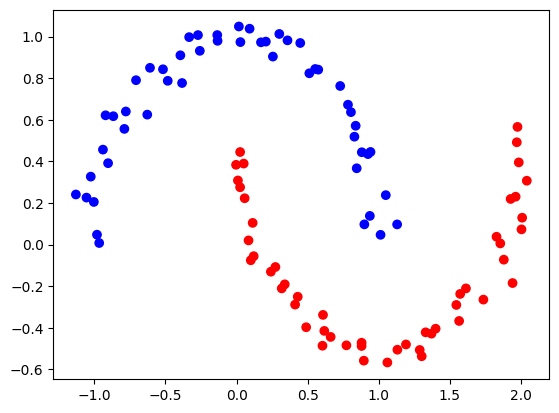

In [12]:
# 重新绘图
plt.scatter(noisy_moons[:, 0], noisy_moons[:, 1], c=dbscan_c, cmap="bwr")

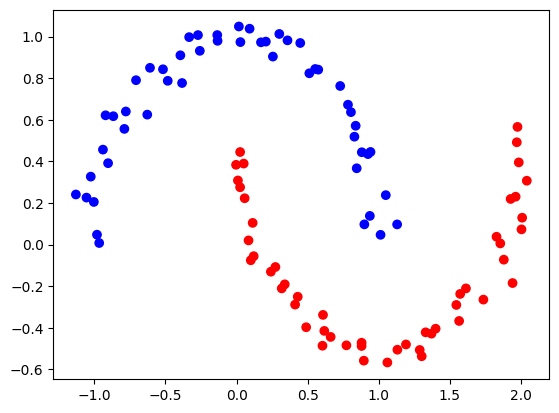

In [13]:
# DBSCAN聚类算法的scikit-learn实现
'''
sklearn.cluster.DBSCAN(eps=0.5, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=1)
    eps: 邻域半径
    min_samples: 密度阈值MinPts
    metric: 距离度量方式，默认为欧氏距离
    algorithm: 近邻算法求解方式，可选auto、ball_tree、kd_tree、brute
'''
from sklearn.cluster import DBSCAN

dbscan_sk = DBSCAN(eps=0.5, min_samples=5, metric="euclidean")
dbscan_sk_c = dbscan_sk.fit_predict(noisy_moons)
plt.scatter(noisy_moons[:, 0], noisy_moons[:, 1], c=dbscan_sk_c, cmap="bwr")

## HDBSCAN聚类算法
 HDBSCAN 直译成中文的意思就是：基于层次密度估计的密度聚类方法

 DBSCAN 受参数变化的影响较大，特别是数据分布密度不均匀时，如果我们把 eps 设置为较小值，那么密度本身较小的类别会被进一步划分为多个子类。同理，当设置 eps 值较大时，会使得距离较近且密度较大类别被合并成一个簇。这也就体现了 DBSCAN 的不稳定性。

 HDBSCAN 通过结合层次聚类的特点来改善 DBSCAN 的不稳定性，故聚类过程变更为 2 个步骤：
* 生成原始聚簇。 此阶段和 DBSCAN 算法的第一阶段相似，确定核心点，生成原始聚簇并有效地识别噪声点
* 合并原始聚簇。 在此阶段使用层次聚类的思想对原始聚簇进行合并，降低了聚类结果对输入参数的敏感性。由于该方法不需要对每个对象进行测试和判断，同时也降低了时间复杂度

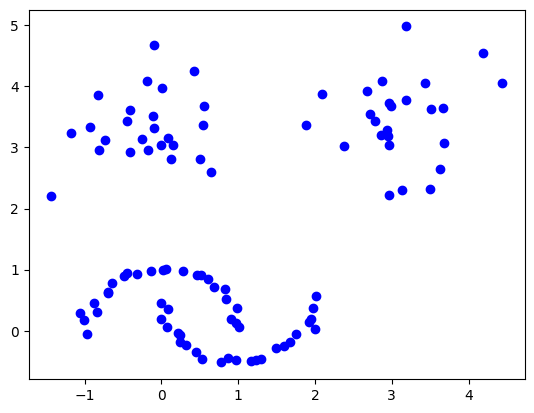

In [14]:
# 重新生成一组示例数据
moons, _ = datasets.make_moons(n_samples=50, noise=0.05, random_state=10)
blobs, _ = datasets.make_blobs(
    n_samples=50, centers=[(-0.25, 3.25), (3, 3.5)], cluster_std=0.6, random_state=10
)

noisy_moons_blobs = np.vstack([moons, blobs])
plt.scatter(noisy_moons_blobs[:, 0], noisy_moons_blobs[:, 1], color="b")

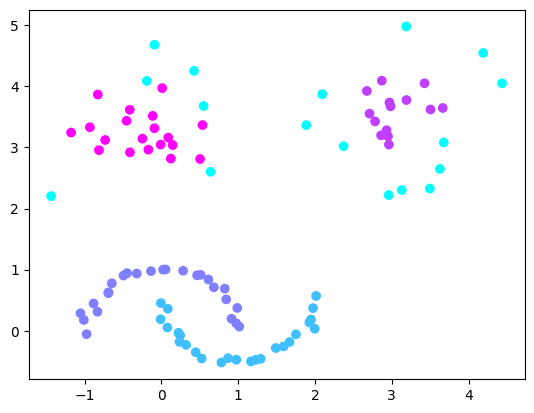

In [15]:
# 首先使用DBSCAN算法，观察结果
dbscan_sk_c = dbscan_sk.fit_predict(noisy_moons_blobs)
plt.scatter(
    noisy_moons_blobs[:, 0], noisy_moons_blobs[:, 1], c=dbscan_sk_c, cmap="cool"
)

DBSCAN 算法将 noisy_moons_blobs 数据集聚为了 4 类，并标记出了团状数据周围的异常点

事实上，通过肉眼观察，noisy_moons_blobs 数据集其实最佳聚类应该是 3 类。虽然我们上面的月牙形数据被划为 2 类，但这里明显将月牙形数据作为一类并与团状数据区分较好，也就是如下图所示

下面尝试调大eps参数

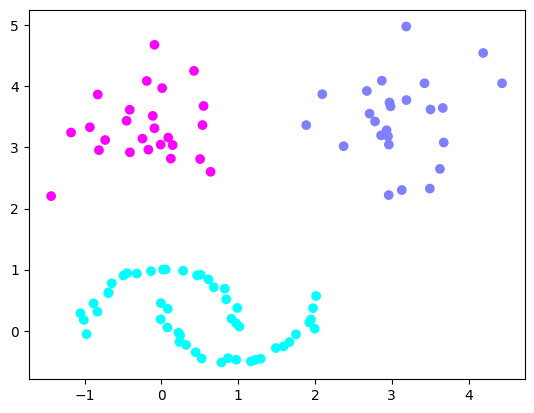

In [16]:
dbscan_sk = DBSCAN(eps=1, min_samples=5, metric="euclidean")
dbscan_sk_c = dbscan_sk.fit_predict(noisy_moons_blobs)
plt.scatter(
    noisy_moons_blobs[:, 0], noisy_moons_blobs[:, 1], c=dbscan_sk_c, cmap="cool"
)

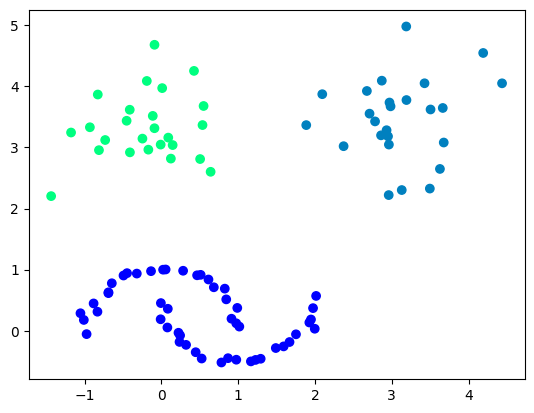

In [17]:
# 使用HDBSCAN
# HDBSCAN 中最主要的参数是 min_cluster_size，它用来决定形成一个类别最小的样本数量。
# 第二个重要参数是 min_samples，简单来讲，min_samples 值越大表示聚类效果越保守，也就是更多的点将会被声明为噪声
import hdbscan

# gen_min_span_tree 参数为下文绘图做准备
hdbscan_m = hdbscan.HDBSCAN(gen_min_span_tree=True)
hdbscan_m_c = hdbscan_m.fit_predict(noisy_moons_blobs)

plt.scatter(
    noisy_moons_blobs[:, 0], noisy_moons_blobs[:, 1], c=hdbscan_m_c, cmap="winter"
)